In [ ]:
#! git clone https://github.com/luke-scot/s4-thermal.git
%cd /content/s4-thermal
%pip install pyproj imutils opencv-python simplekml palettable gdown
!pip install --upgrade -q pyproj

# Image processing pipeline - tuned on library
First import the packages to set up

In [39]:
# Import necessary packages
#%pip install imutils opencv-python simplekml palettable gdown
import helper_functions as hf
import plotting as pl
import stitching as st
import gdown
import os
import glob
#import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
import cv2
import imageio
import imutils
from palettable import colorbrewer
from scipy import ndimage
from collections import Counter
from itertools import compress
cv2.ocl.setUseOpenCL(False)

In [44]:
# Variables
gdrive = True # Download data from google drive
link = 'https://drive.google.com/file/d/1FotJ04cV7WmiLhFJG9-5DtOL60_cPJE1/view?usp=sharing' # gdrive link
flightLink = 'https://drive.google.com/file/d/1nF7wNmow4v5cgTMATEVe7tYYuOY1SZTQ/view?usp=sharing'
imgDir = "NIAB-210804-12mdata/" # Local directory to images
imageType, cmap = False, colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap # True if RGB images, False if numpy arrays. Choose matplotlib cmap for thermal
pathFile = "NIAB-210804-12m-path.csv" # Flight path .csv file
outName = 'NIAB_12m_210804'
utcDiff = -1 # Time difference to UTC (-1 for BST)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)','speed(mps)','isflying'] # Columns used from the path file
filters = ['altitude(m)','speed(mps)','yaw(deg)']#,'roll(deg)','pitch(deg)', 'timestamp']#, 'speed(mps)'] # Altitude criteria for using imagery
filtValues = [[11.7, 12.3], [0.85,1.15], [-54.5, -53]] #, [-5,5],[-5,5]]#, [1619811011923,1619811099149], [4.85,5.15]]
#filtValues = [[119.7, 120.3], [2.85,3.15], [-10,10],[-10,10], [-60, -50],[1628076689215,1628076933204]]
#filtValues = [[11.7, 12.3], [-60, -50], [2.85,3.15], [-5,5],[-5,5]]#, [1619811011923,1619811099149], [4.85,5.15]]
#filtValues = [[119.7, 120.3], [-60, -50], [2.85,3.15], [1626693113971,1626693164952], [-10,10],[-10,10]]#, [1619811011923,1619811099149], [4.85,5.15]]
utmZone, hemisphere = '31', 'north' # Specify UTM coordinate zone
resolution = 6 # Other resolution for plots
useCentre = True # True if only using center of images
skip = 20 # Plot every nth image for path
height = 12 # Height of camera
fov, pixels = 69, 640 # Long axis field of view and number of pixels of camera
pxSize = (height*np.tan(np.deg2rad(fov/2)))/(pixels/2) # Specify pixel size (m) - for now

In [35]:
# Download from google drive if gdrive is True
%%capture
if gdrive:
  # zippath = imgDir[:-1]+'.zip'
  # downLink = 'https://drive.google.com/uc?id='+link.split('/d/')[1].split('/view')[0] 
  # #gdown.download('https://drive.google.com/uc?export=download&id='+downLink, zippath,quiet=True)
  # #! gdown -O $zippath 'https://drive.google.com/uc?export=download&id='$downLink
  # ! mkdir $imgDir
  # gdown.download(downLink, zippath, quiet=False)

  # ! unzip $zippath -d $imgDir
  # ! rm $zippath

  gdown.download('https://drive.google.com/uc?id='+flightLink.split('/d/')[1].split('/view')[0],pathFile,quiet=True)

In [20]:
zippath

'data/NIAB-210804/4 August 2021/Flight 2/thermal-data.zip'

## 1 - Filter images and present sample

In [47]:
def reproject_coords(df, utmZone, hemisphere='north', inverse=False, 
                     orig=['longitude','latitude'], local=['x','y']):
    """Reprojects coordinates in dataframe to new column
    
    Input:
    df - Dataframe containg coordinates
    utmZone - WGS84 UTM zone
    hemisphere - north or south
    inverse - False for lat/lon to local, True for local to lat/lon
    
    Output:
    df - Dataframe with new column for coordinates
    """
    # Convert coordinates to UTM
    myProj = Proj(proj='utm', zone=utmZone, ellps='WGS84', preserve_units=False)
    if inverse: df[orig[0]], df[orig[1]] = myProj(df[local[0]].values, df[local[1]].values, inverse=True)
    else: df[local[0]], df[local[1]] = myProj(df[orig[0]].values, df[orig[1]].values)
    return df, myProj

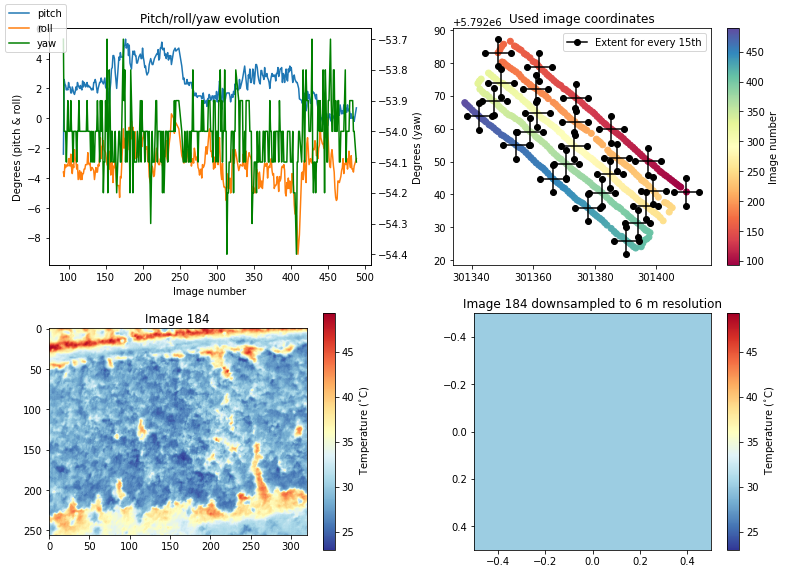

In [48]:
# Create dataframe of images associated with flight information
merged = hf.img_info_merge(imgDir, pathFile, utcDiff, pathColumns, imageType)
merged = hf.filter_imgs(merged, filters, filtValues)
merged, myProj = reproject_coords(merged, utmZone, hemisphere)
idf = hf.correct_coords(merged, 20)

# Plot summary of flight and example image
fig, axs = plt.subplots(2,2,figsize=[11,8])
fig, axs[0,0] = pl.plot_orientation(fig, axs[0,0], merged) 
xq, yq, xCoords, yCoords = hf.use_centre(useCentre, idf, pxSize)
fig, axs[0,1] = pl.plot_route(fig, axs[0,1], idf, xq, yq, pxSize)
fig, axs[1,0] = pl.plot_image(fig, axs[1,0], idf, xq, yq, pxSize, pxSize, cmap, imageType=imageType)
fig, axs[1,1] = pl.plot_image(fig, axs[1,1], idf, xq, yq, pxSize, resolution, cmap, imageType=imageType)
fig.tight_layout()
plt.show()

## 2 - Merge according to xy coordinates

Images processed: 368it [00:41,  8.94it/s]


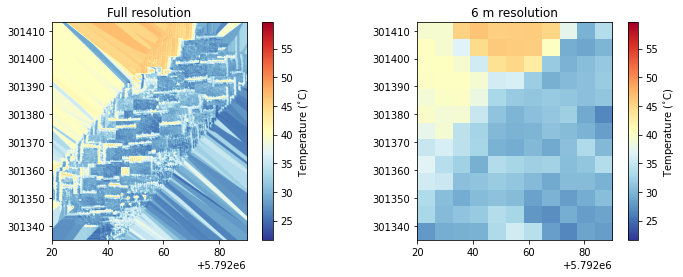

In [49]:
# Stitch images based on xy coordinates
xygrid, extent = st.img_xymerge(idf, xCoords, yCoords, xq, yq, pxSize, imageType=imageType)

# Plot output and downsample
fig, axs = plt.subplots(1,2,figsize=[12,4])
fig, axs[0] = pl.plot_array(fig, axs[0], xygrid, extent, cmap=cmap, title='Full resolution', imageType=imageType)
fig, axs[1] = pl.plot_array(fig, axs[1], hf.downsample_arr(xygrid,pxSize,resolution), extent, cmap=cmap, title=str(resolution)+' m resolution', imageType=imageType, scale=xygrid)

In [ ]:
# Save as .kmz file
inputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, single = pl.plot_kml(xygrid, conv, outName+'_xymerge', 1024*10, rot=90, cmap=cmap)
_, ds = pl.plot_kml(hf.downsample_arr(xygrid,pxSize,resolution), conv, outName+'_ds_xymerge', 1024*10, rot=90, scale=xygrid, cmap=cmap)
pl.plot_kml_legend(cs, outName+'_xylegend')
pl.plot_kml_path(idf, conv, outName+'_xypath', 1024*10)
pl.make_kml(conv, figs=[outName+'_xymerge.png', outName+'_ds_xymerge.png', outName+'_xypath.png'], 
            colorbar=outName+'_xylegend.png', kmzfile=outName+'xymerge_thermal.kmz',
            description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')    

In [ ]:
pl.save_to_csv(ds, single, conv, pxSize, resolution, outName+'_xymerge')

## 3 - Stitch using RANSAC algorithm
Stitch each flight line into individual strip

In [ ]:
# Multi-image stitching
# Setup variables
tempfiles = ['temp0.jpg','temp1.jpg']
start, end, step = 0, len(idf), 1
tmin, tmax = int(np.floor(xygrid.min()))-1, int(np.ceil(xygrid.max()))+1
lineDist = 2
imgPath='imgPath'
skips=[]

strips = {}
# Loop over all images
while start < end-1:

    prev, single, prevImg, totalBox, prevBox = st.initialise_vars(idf, start, xq, yq, tmin, tmax, path=imgPath)
    
    # Loop over images until break in continuous line
    for imgNum in tqdm(np.arange(start+step if start < end else start-step, end, step if start < end else -step)):
        if (np.hypot(abs(idf.iloc[imgNum]['xc']-idf.iloc[imgNum-1]['xc']),abs(idf.iloc[imgNum]['yc']-idf.iloc[imgNum-1]['yc']))) > lineDist:
            break
        if imgNum in skips: continue # Skip iteration if img in skips
        arrs = [hf.img_to_arr(idf.iloc[i][imgPath], xq=xq, yq=yq) for i in [prev, imgNum]]

#         for i, val in enumerate(tempfiles): 
#             single = ((arrs[i]-tmin)*255/tmax).astype(np.uint8)
#             if i==0: trainImg=np.dstack((single,single,single))
#             else: queryImg=np.dstack((single,single,single))
        
        for i, val in enumerate(tempfiles): 
            single = ((arrs[i]-tmin)*255/tmax).astype(np.uint8)
            imageio.imwrite(val,np.dstack((single,single,single)))
        # Read images - Make sure that the train image is the image that will be transformed
        trainImg, queryImg = [imageio.imread(i) for i in tempfiles]

        ma, mb, _ = st.get_img_translation(trainImg, queryImg)

        mam, mbm, diff = st.filter_img_translation(ma, mb, idf, prev, imgNum)

        totalBox, prevNew, prevImg, prevBox = st.stitch_img_result(mam, mbm, diff, totalBox, prevBox, arrs, prevImg,
                                                                prev, imgNum, min_matches=2, max_stdev=30, verbose=False)
        
        if prevNew < imgNum-3:
            imgNum = prevNew+1
            break
        else: prev=prevNew
        
    #if start<imgNum-1: 
    strips.update({start:prevImg})
    start = imgNum

ks = np.array(list(strips.keys()))
mn = strips[ks[0]].mean() # Get mean from first for scaling
for i in ks:
    read = ((strips[i]-strips[i].mean()+mn)*np.ma.masked_where(strips[i]!=0, strips[i]).mask).astype(np.uint8) # Rescale while keeping 0 values
    imageio.imwrite('strips/'+outName+'_'+str(i)+'.jpg',np.dstack((read[:,:,0],read[:,:,1],read[:,:,2])))
    
for i in tempfiles: os.remove(i)

In [51]:
#%matplotlib inline
# Multi-image stitching
# Setup variables
tempfiles = ['temp0.jpg','temp1.jpg']
start, end, step = 0, len(idf), 1
tmin, tmax = int(np.floor(xygrid.min())), int(np.ceil(xygrid.max()))
lineDist = 2
imgPath='imgPath'
skips=[]

strips = {}
# Loop over all images
while start < end-1:

    prev, single, prevImg, totalBox, prevBox = st.initialise_vars(idf, start, xq, yq, tmin, tmax, path=imgPath)
    
    # Loop over images until break in continuous line
    for imgNum in tqdm(np.arange(start+step if start < end else start-step, end, step if start < end else -step)):
        if (np.hypot(abs(idf.iloc[imgNum]['xc']-idf.iloc[imgNum-1]['xc']),abs(idf.iloc[imgNum]['yc']-idf.iloc[imgNum-1]['yc']))) > lineDist:
            break
        if imgNum in skips: continue # Skip iteration if img in skips
        arrs = [hf.img_to_arr(idf.iloc[i][imgPath], xq=xq, yq=yq) for i in [prev, imgNum]]

        for i, val in enumerate(tempfiles): 
            single = ((arrs[i]-tmin)*255/tmax).astype(np.uint8)
            if i==0: trainImg=np.dstack((single,single,single))
            else: queryImg=np.dstack((single,single,single))
            #imageio.imwrite(val,np.dstack((single,single,single)))
            
        # Read images - Make sure that the train image is the image that will be transformed
        #trainImg, queryImg = [imageio.imread(i) for i in tempfiles]

        ma, mb, _ = st.get_img_translation(trainImg, queryImg)

        mam, mbm, diff = st.filter_img_translation(ma, mb, idf, prev, imgNum)

        totalBox, prevNew, prevImg, prevBox = st.stitch_img_result(mam, mbm, diff, totalBox, prevBox, arrs, prevImg,
                                                                prev, imgNum, min_matches=4, max_stdev=30, verbose=True,queryImg=queryImg)
        
        if prevNew < imgNum-3:
            imgNum = prevNew+1
            break
        else: prev=prevNew
        
    #if start<imgNum-1: 
    # result = np.ma.masked_where(prevImg==0, prevImg)
    # conv = np.array(myProj(np.array(sorted([idf.iloc[start].xc, idf.iloc[imgNum].xc]))+[-add, add], np.array(sorted([idf.iloc[start].yc, idf.iloc[imgNum].yc]))+[-add, add], inverse=True))
    # cs, _ = plot_kml(result.data, conv, 'strips_kmz/'+outName+'_'+str(start), 1024*10, rot=rot, temp=False, scale=np.array([13,37]), tmin=tmin, tmax=tmax,cmap=cmap, add_temp=-13, filt=2, hide_plot=True)

    strips.update({start:prevImg})
    start = imgNum

if not os.path.isdir('strips/'):
  ! mkdir 'strips'

ks = np.array(list(strips.keys()))
mn = strips[ks[0]].mean() # Get mean from first for scaling
for i in ks:
    read=strips[i]
    read = ((strips[i]-strips[i].mean()+mn)*np.ma.masked_where(strips[i]!=0, strips[i]).mask).astype(np.uint8) # Rescale while keeping 0 values
    imageio.imwrite('strips/'+outName+'_'+str(i)+'.jpg',np.dstack((read[:,:,0],read[:,:,1],read[:,:,2])))
    
# for i in tempfiles: os.remove(i)

  2%|▏         | 9/366 [00:00<00:09, 37.56it/s]

Raw matches (Brute force): 89
Filt. matches: 89, stdev: 38.58
Removed outliers
Images 1 and 2 merged.
Raw matches (Brute force): 98
Filt. matches: 98, stdev: 35.27
Removed outliers
Images 2 and 3 merged.
Raw matches (Brute force): 115
Filt. matches: 115, stdev: 29.17
Images 3 and 4 merged.
Raw matches (Brute force): 124
Filt. matches: 124, stdev: 28.68
Images 4 and 5 merged.
Raw matches (Brute force): 129
Filt. matches: 129, stdev: 25.05
Images 5 and 6 merged.
Raw matches (Brute force): 94
Filt. matches: 94, stdev: 24.78
Images 6 and 7 merged.
Raw matches (Brute force): 79
Filt. matches: 79, stdev: 24.34
Images 7 and 8 merged.
Raw matches (Brute force): 70
Filt. matches: 70, stdev: 38.5
Removed outliers
Images 8 and 9 merged.
Raw matches (Brute force): 75
Filt. matches: 75, stdev: 40.79
Removed outliers
Images 9 and 10 merged.


  4%|▍         | 14/366 [00:00<00:09, 38.58it/s]

Raw matches (Brute force): 86
Filt. matches: 86, stdev: 22.14
Images 10 and 11 merged.
Raw matches (Brute force): 112
Filt. matches: 112, stdev: 25.7
Images 11 and 12 merged.
Raw matches (Brute force): 114
Filt. matches: 114, stdev: 28.13
Images 12 and 13 merged.
Raw matches (Brute force): 143
Filt. matches: 143, stdev: 16.4
Images 13 and 14 merged.
Raw matches (Brute force): 165
Filt. matches: 165, stdev: 17.85
Images 14 and 15 merged.
Raw matches (Brute force): 200
Filt. matches: 200, stdev: 16.25
Images 15 and 16 merged.
Raw matches (Brute force): 219
Filt. matches: 219, stdev: 21.7
Images 16 and 17 merged.
Raw matches (Brute force): 202
Filt. matches: 202, stdev: 26.41
Images 17 and 18 merged.


  6%|▌         | 21/366 [00:00<00:10, 33.61it/s]

Raw matches (Brute force): 219
Filt. matches: 219, stdev: 24.52
Images 18 and 19 merged.
Raw matches (Brute force): 207
Filt. matches: 207, stdev: 28.0
Images 19 and 20 merged.
Raw matches (Brute force): 201
Filt. matches: 201, stdev: 21.04
Images 20 and 21 merged.
Raw matches (Brute force): 220
Filt. matches: 220, stdev: 22.94
Images 21 and 22 merged.
Raw matches (Brute force): 165
Filt. matches: 165, stdev: 36.84
Removed outliers
Images 22 and 23 merged.
Raw matches (Brute force): 173
Filt. matches: 173, stdev: 14.64
Images 23 and 24 merged.
Raw matches (Brute force): 132
Filt. matches: 132, stdev: 21.95


  8%|▊         | 29/366 [00:00<00:10, 32.89it/s]

Images 24 and 25 merged.
Raw matches (Brute force): 148
Filt. matches: 148, stdev: 25.13
Images 25 and 26 merged.
Raw matches (Brute force): 169
Filt. matches: 169, stdev: 25.92
Images 26 and 27 merged.
Raw matches (Brute force): 181
Filt. matches: 181, stdev: 14.33
Images 27 and 28 merged.
Raw matches (Brute force): 162
Filt. matches: 162, stdev: 23.21
Images 28 and 29 merged.
Raw matches (Brute force): 134
Filt. matches: 134, stdev: 29.39
Images 29 and 30 merged.
Raw matches (Brute force): 97
Filt. matches: 97, stdev: 47.63
Removed outliers
Images 30 and 31, poor matching
Raw matches (Brute force): 91
Filt. matches: 62, stdev: 23.06


 10%|█         | 37/366 [00:01<00:10, 32.69it/s]

Images 30 and 32 merged.
Raw matches (Brute force): 121
Filt. matches: 121, stdev: 28.38
Images 32 and 33 merged.
Raw matches (Brute force): 107
Filt. matches: 107, stdev: 10.98
Images 33 and 34 merged.
Raw matches (Brute force): 82
Filt. matches: 82, stdev: 22.03
Images 34 and 35 merged.
Raw matches (Brute force): 78
Filt. matches: 78, stdev: 23.23
Images 35 and 36 merged.
Raw matches (Brute force): 63
Filt. matches: 63, stdev: 42.23
Removed outliers
Images 36 and 37 merged.
Raw matches (Brute force): 71
Filt. matches: 71, stdev: 32.0
Removed outliers
Images 37 and 38 merged.
Raw matches (Brute force): 64
Filt. matches: 64, stdev: 41.78
Removed outliers


 11%|█         | 41/366 [00:01<00:10, 30.85it/s]

Images 38 and 39 merged.
Raw matches (Brute force): 80
Filt. matches: 80, stdev: 36.32
Removed outliers
Images 39 and 40 merged.
Raw matches (Brute force): 90
Filt. matches: 90, stdev: 28.22
Images 40 and 41 merged.
Raw matches (Brute force): 79
Filt. matches: 79, stdev: 15.21
Images 41 and 42 merged.
Raw matches (Brute force): 65
Filt. matches: 65, stdev: 34.16
Removed outliers
Images 42 and 43 merged.
Raw matches (Brute force): 57
Filt. matches: 57, stdev: 45.26
Removed outliers
Images 43 and 44 merged.


 13%|█▎        | 48/366 [00:01<00:11, 27.53it/s]

Raw matches (Brute force): 91
Filt. matches: 91, stdev: 24.99
Images 44 and 45 merged.
Raw matches (Brute force): 168
Filt. matches: 168, stdev: 28.38
Images 45 and 46 merged.
Raw matches (Brute force): 204
Filt. matches: 204, stdev: 10.22
Images 46 and 47 merged.
Raw matches (Brute force): 236
Filt. matches: 236, stdev: 20.53
Images 47 and 48 merged.
Raw matches (Brute force): 197
Filt. matches: 197, stdev: 15.26
Images 48 and 49 merged.
Raw matches (Brute force): 105
Filt. matches: 105, stdev: 6.34


 15%|█▌        | 55/366 [00:01<00:10, 29.77it/s]

Images 49 and 50 merged.
Raw matches (Brute force): 28
Filt. matches: 28, stdev: 46.44
Removed outliers
Images 50 and 51 merged.
Raw matches (Brute force): 27
Filt. matches: 27, stdev: 59.48
Removed outliers
Images 51 and 52 merged.
Raw matches (Brute force): 18
Filt. matches: 18, stdev: 44.17
Removed outliers
Images 52 and 53, poor matching
Raw matches (Brute force): 51
Filt. matches: 48, stdev: 3.28
Images 52 and 54 merged.
Raw matches (Brute force): 75
Filt. matches: 75, stdev: 13.49
Images 54 and 55 merged.
Raw matches (Brute force): 51
Filt. matches: 51, stdev: 17.09
Images 55 and 56 merged.


  0%|          | 0/309 [00:00<?, ?it/s]

Raw matches (Brute force): 49
Filt. matches: 49, stdev: 0.95
Images 56 and 57 merged.
Raw matches (Brute force): 17
Filt. matches: 17, stdev: 71.86
Removed outliers
Images 57 and 58, poor matching
Raw matches (Brute force): 26
Filt. matches: 3, stdev: 0.56
Images 57 and 59, poor matching
Raw matches (Brute force): 17
Filt. matches: 2, stdev: 29.12
Images 57 and 60, poor matching
Raw matches (Brute force): 29
Filt. matches: 6, stdev: 59.98
Removed outliers
Images 57 and 61, poor matching
Raw matches (Brute force): 28
Filt. matches: 28, stdev: 38.89
Removed outliers
Images 58 and 59 merged.
Raw matches (Brute force): 51
Filt. matches: 51, stdev: 15.9
Images 59 and 60 merged.
Raw matches (Brute force): 72
Filt. matches: 72, stdev: 5.53
Images 60 and 61 merged.
Raw matches (Brute force): 108
Filt. matches: 108, stdev: 10.39
Images 61 and 62 merged.


  2%|▏         | 5/309 [00:00<00:06, 45.30it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
  0%|          | 0/303 [00:00<?, ?it/s]

Raw matches (Brute force): 44
Filt. matches: 44, stdev: 0.86
Images 62 and 63 merged.
Raw matches (Brute force): 15
Filt. matches: 9, stdev: 54.15
Removed outliers
Images 63 and 64, poor matching
Raw matches (Brute force): 27
Filt. matches: 3, stdev: 0.34
Images 63 and 65, poor matching
Raw matches (Brute force): 32
Filt. matches: 2, stdev: 0.25
Images 63 and 66, poor matching
Raw matches (Brute force): 30
Filt. matches: 0, stdev: nan
Images 63 and 67, poor matching
Raw matches (Brute force): 32
Filt. matches: 28, stdev: 0.82
Images 64 and 65 merged.
Raw matches (Brute force): 141
Filt. matches: 141, stdev: 13.35
Images 65 and 66 merged.
Raw matches (Brute force): 183
Filt. matches: 2, stdev: 45.4
Images 66 and 67, poor matching
Raw matches (Brute force): 162
Filt. matches: 162, stdev: 9.9
Images 66 and 68 merged.


  0%|          | 0/291 [00:00<?, ?it/s]

Raw matches (Brute force): 96
Filt. matches: 96, stdev: 4.8
Images 68 and 69 merged.
Raw matches (Brute force): 13
Filt. matches: 13, stdev: 84.21
Removed outliers
Images 69 and 70, poor matching
Raw matches (Brute force): 36
Filt. matches: 1, stdev: 0.0
Images 69 and 71, poor matching
Raw matches (Brute force): 8
Filt. matches: 8, stdev: 75.06
Removed outliers
Images 72 and 73, poor matching
Raw matches (Brute force): 24
Filt. matches: 8, stdev: 53.66
Removed outliers
Images 72 and 74, poor matching
Raw matches (Brute force): 26
Filt. matches: 8, stdev: 38.59
Removed outliers
Images 72 and 75, poor matching
Raw matches (Brute force): 23
Filt. matches: 23, stdev: 56.27
Removed outliers
Images 76 and 77 merged.
Raw matches (Brute force): 26
Filt. matches: 26, stdev: 59.63
Removed outliers
Images 77 and 78 merged.
Raw matches (Brute force): 101
Filt. matches: 101, stdev: 0.8
Images 78 and 79 merged.
Raw matches (Brute force): 172


  4%|▍         | 11/291 [00:00<00:05, 48.53it/s]

Filt. matches: 172, stdev: 3.2
Images 79 and 80 merged.
Raw matches (Brute force): 157
Filt. matches: 157, stdev: 8.76
Images 80 and 81 merged.
Raw matches (Brute force): 72
Filt. matches: 72, stdev: 8.92
Images 81 and 82 merged.
Raw matches (Brute force): 11
Filt. matches: 11, stdev: 76.32
Removed outliers
Images 82 and 83 merged.
Raw matches (Brute force): 10
Filt. matches: 10, stdev: 6.98
Images 83 and 84 merged.
Raw matches (Brute force): 37
Filt. matches: 37, stdev: 16.07
Images 84 and 85 merged.
Raw matches (Brute force): 66
Filt. matches: 66, stdev: 0.9
Images 85 and 86 merged.
Raw matches (Brute force): 78
Filt. matches: 78, stdev: 0.81
Images 86 and 87 merged.
Raw matches (Brute force): 46
Filt. matches: 46, stdev: 3.93
Images 87 and 88 merged.
Raw matches (Brute force): 3
Filt. matches: 3, stdev: 0.34
Images 88 and 89, poor matching
Raw matches (Brute force): 7
Filt. matches: 6, stdev: 61.87
Removed outliers
Images 88 and 90, poor matching
Raw matches (Brute force): 19
Filt. 

  0%|          | 0/275 [00:00<?, ?it/s]

Raw matches (Brute force): 30
Filt. matches: 29, stdev: 53.92
Removed outliers
Images 88 and 92, poor matching
Raw matches (Brute force): 2
Filt. matches: 2, stdev: 54.15
Images 89 and 90, poor matching
Raw matches (Brute force): 2
Filt. matches: 2, stdev: 15.45
Images 89 and 91, poor matching
Raw matches (Brute force): 2
Filt. matches: 2, stdev: 9.45
Images 89 and 92, poor matching
Raw matches (Brute force): 2
Filt. matches: 2, stdev: 15.55
Images 89 and 93, poor matching
Raw matches (Brute force): 14
Filt. matches: 14, stdev: 29.71
Images 90 and 91 merged.
Raw matches (Brute force): 75
Filt. matches: 1, stdev: 0.0
Images 91 and 92, poor matching
Raw matches (Brute force): 62
Filt. matches: 1, stdev: 0.0
Images 91 and 93, poor matching
Raw matches (Brute force): 50
Filt. matches: 1, stdev: 0.0
Images 91 and 94, poor matching
Raw matches (Brute force): 26
Filt. matches: 2, stdev: 73.55
Images 91 and 95, poor matching


  2%|▏         | 5/275 [00:00<00:05, 48.24it/s]

Raw matches (Brute force): 94
Filt. matches: 94, stdev: 4.44
Images 92 and 93 merged.
Raw matches (Brute force): 81
Filt. matches: 81, stdev: 5.73
Images 93 and 94 merged.
Raw matches (Brute force): 41
Filt. matches: 41, stdev: 38.62
Removed outliers
Images 94 and 95 merged.
Raw matches (Brute force): 28
Filt. matches: 25, stdev: 55.79
Removed outliers
Images 95 and 96, poor matching
Raw matches (Brute force): 29
Filt. matches: 26, stdev: 59.27
Removed outliers
Images 95 and 97, poor matching


  2%|▏         | 6/271 [00:00<00:07, 36.54it/s]

Raw matches (Brute force): 29
Filt. matches: 26, stdev: 57.45
Removed outliers
Images 95 and 98, poor matching
Raw matches (Brute force): 30
Filt. matches: 24, stdev: 53.74
Removed outliers
Images 95 and 99, poor matching
Raw matches (Brute force): 97
Filt. matches: 97, stdev: 9.81
Images 96 and 97 merged.
Raw matches (Brute force): 147
Filt. matches: 147, stdev: 6.95
Images 97 and 98 merged.
Raw matches (Brute force): 123
Filt. matches: 123, stdev: 7.71
Images 98 and 99 merged.
Raw matches (Brute force): 39
Filt. matches: 39, stdev: 18.81
Images 99 and 100 merged.
Raw matches (Brute force): 7
Filt. matches: 7, stdev: 51.29
Removed outliers
Images 100 and 101, poor matching
Raw matches (Brute force): 26
Filt. matches: 24, stdev: 37.91
Removed outliers
Images 100 and 102, poor matching
Raw matches (Brute force): 30
Filt. matches: 30, stdev: 44.81
Removed outliers
Images 100 and 103, poor matching
Raw matches (Brute force): 30
Filt. matches: 29, stdev: 47.03
Removed outliers
Images 100 a


  0%|          | 0/260 [00:00<?, ?it/s]

Raw matches (Brute force): 10
Filt. matches: 10, stdev: 0.49
Images 101 and 102 merged.
Raw matches (Brute force): 57
Filt. matches: 57, stdev: 16.11
Images 102 and 103 merged.
Raw matches (Brute force): 138
Filt. matches: 138, stdev: 3.05
Images 103 and 104 merged.
Raw matches (Brute force): 149
Filt. matches: 149, stdev: 9.52
Images 104 and 105 merged.
Raw matches (Brute force): 94
Filt. matches: 94, stdev: 10.13
Images 105 and 106 merged.
Raw matches (Brute force): 28
Filt. matches: 28, stdev: 76.5
Removed outliers
Images 106 and 107, poor matching
Raw matches (Brute force): 40
Filt. matches: 30, stdev: 54.4
Removed outliers
Images 106 and 108, poor matching
Raw matches (Brute force): 38
Filt. matches: 32, stdev: 52.89
Removed outliers
Images 106 and 109, poor matching
Raw matches (Brute force): 40
Filt. matches: 35, stdev: 54.94
Removed outliers
Images 106 and 110, poor matching


  0%|          | 0/251 [00:00<?, ?it/s]

Raw matches (Brute force): 31
Filt. matches: 31, stdev: 58.8
Removed outliers
Images 107 and 108, poor matching
Raw matches (Brute force): 29
Filt. matches: 8, stdev: 57.91
Removed outliers
Images 107 and 109, poor matching
Raw matches (Brute force): 28
Filt. matches: 12, stdev: 58.95
Removed outliers
Images 107 and 110 merged.
Raw matches (Brute force): 18
Filt. matches: 2, stdev: 11.22
Images 110 and 111, poor matching
Raw matches (Brute force): 83
Filt. matches: 83, stdev: 15.98
Images 112 and 113 merged.
Raw matches (Brute force): 95
Filt. matches: 95, stdev: 0.82
Images 113 and 114 merged.
Raw matches (Brute force): 82
Filt. matches: 82, stdev: 16.21
Images 114 and 115 merged.
Raw matches (Brute force): 2
Filt. matches: 2, stdev: 79.04
Images 116 and 117, poor matching
Raw matches (Brute force): 12
Filt. matches: 8, stdev: 85.74
Removed outliers
Images 116 and 118, poor matching


  0%|          | 0/249 [00:00<?, ?it/s]

Raw matches (Brute force): 27
Filt. matches: 19, stdev: 81.38
Removed outliers
Images 116 and 119, poor matching
Raw matches (Brute force): 26
Filt. matches: 21, stdev: 88.56
Removed outliers
Images 116 and 120, poor matching
Raw matches (Brute force): 3
Filt. matches: 3, stdev: 30.29
Images 117 and 118, poor matching
Raw matches (Brute force): 4
Filt. matches: 4, stdev: 36.45
Images 117 and 119, poor matching
Raw matches (Brute force): 5
Filt. matches: 5, stdev: 60.52
Removed outliers
Images 117 and 120, poor matching
Raw matches (Brute force): 3
Filt. matches: 3, stdev: 41.19
Images 117 and 121, poor matching
Raw matches (Brute force): 19
Filt. matches: 19, stdev: 1.08
Images 118 and 119 merged.
Raw matches (Brute force): 70
Filt. matches: 70, stdev: 5.57
Images 119 and 120 merged.
Raw matches (Brute force): 72
Filt. matches: 72, stdev: 2.47
Images 120 and 121 merged.
Raw matches (Brute force): 68
Filt. matches: 68, stdev: 5.88


  0%|          | 0/243 [00:00<?, ?it/s]

Images 121 and 122 merged.
Raw matches (Brute force): 9
Filt. matches: 9, stdev: 55.05
Removed outliers
Images 122 and 123, poor matching
Raw matches (Brute force): 18
Filt. matches: 0, stdev: nan
Images 122 and 124, poor matching
Raw matches (Brute force): 31
Filt. matches: 3, stdev: 45.17
Images 122 and 125, poor matching
Raw matches (Brute force): 39
Filt. matches: 2, stdev: 24.35
Images 122 and 126, poor matching
Raw matches (Brute force): 7
Filt. matches: 7, stdev: 33.88
Removed outliers
Images 123 and 124, poor matching
Raw matches (Brute force): 6
Filt. matches: 0, stdev: nan
Images 123 and 125, poor matching
Raw matches (Brute force): 8
Filt. matches: 1, stdev: 0.0
Images 123 and 126, poor matching
Raw matches (Brute force): 10
Filt. matches: 0, stdev: nan
Images 123 and 127, poor matching
Raw matches (Brute force): 12
Filt. matches: 12, stdev: 70.07
Removed outliers
Images 124 and 125 merged.
Raw matches (Brute force): 90
Filt. matches: 90, stdev: 4.54


  0%|          | 0/236 [00:00<?, ?it/s]

Images 125 and 126 merged.
Raw matches (Brute force): 111
Filt. matches: 111, stdev: 20.28
Images 126 and 127 merged.
Raw matches (Brute force): 144
Filt. matches: 144, stdev: 0.89
Images 127 and 128 merged.
Raw matches (Brute force): 135
Filt. matches: 135, stdev: 4.39
Images 128 and 129 merged.
Raw matches (Brute force): 64
Filt. matches: 64, stdev: 11.77
Images 129 and 130 merged.
Raw matches (Brute force): 25
Filt. matches: 25, stdev: 68.27
Removed outliers
Images 130 and 131, poor matching
Raw matches (Brute force): 30
Filt. matches: 3, stdev: 26.24
Images 130 and 132, poor matching
Raw matches (Brute force): 33
Filt. matches: 0, stdev: nan
Images 130 and 133, poor matching
Raw matches (Brute force): 39
Filt. matches: 5, stdev: 33.78
Removed outliers
Images 130 and 134, poor matching
Raw matches (Brute force): 19
Filt. matches: 19, stdev: 52.14
Removed outliers
Images 131 and 132 merged.


  0%|          | 0/229 [00:00<?, ?it/s]

Raw matches (Brute force): 75
Filt. matches: 75, stdev: 26.55
Images 132 and 133 merged.
Raw matches (Brute force): 150
Filt. matches: 150, stdev: 14.34
Images 133 and 134 merged.
Raw matches (Brute force): 108
Filt. matches: 108, stdev: 16.66
Images 134 and 135 merged.
Raw matches (Brute force): 52
Filt. matches: 52, stdev: 35.5
Removed outliers
Images 135 and 136 merged.
Raw matches (Brute force): 31
Filt. matches: 26, stdev: 31.2
Removed outliers
Images 136 and 137 merged.
Raw matches (Brute force): 144
Filt. matches: 144, stdev: 6.42
Images 138 and 139 merged.
Raw matches (Brute force): 83
Filt. matches: 83, stdev: 20.61
Images 139 and 140 merged.
Raw matches (Brute force): 26
Filt. matches: 26, stdev: 80.19
Removed outliers
Images 140 and 141, poor matching
Raw matches (Brute force): 43


  0%|          | 0/220 [00:00<?, ?it/s]

Filt. matches: 15, stdev: 52.43
Removed outliers
Images 140 and 142 merged.
Raw matches (Brute force): 139
Filt. matches: 139, stdev: 28.86
Images 143 and 144 merged.
Raw matches (Brute force): 91
Filt. matches: 91, stdev: 18.99
Images 144 and 145 merged.
Raw matches (Brute force): 24
Filt. matches: 24, stdev: 22.29
Images 145 and 146 merged.
Raw matches (Brute force): 19
Filt. matches: 19, stdev: 71.69
Removed outliers
Images 146 and 147, poor matching
Raw matches (Brute force): 23
Filt. matches: 21, stdev: 53.85
Removed outliers
Images 146 and 148, poor matching
Raw matches (Brute force): 21
Filt. matches: 20, stdev: 53.35
Removed outliers
Images 146 and 149, poor matching
Raw matches (Brute force): 25
Filt. matches: 23, stdev: 52.43
Removed outliers
Images 146 and 150, poor matching
Raw matches (Brute force): 56
Filt. matches: 56, stdev: 15.69
Images 147 and 148 merged.


  0%|          | 0/214 [00:00<?, ?it/s]

Raw matches (Brute force): 118
Filt. matches: 118, stdev: 9.43
Images 148 and 149 merged.
Raw matches (Brute force): 155
Filt. matches: 155, stdev: 9.11
Images 149 and 150 merged.
Raw matches (Brute force): 127
Filt. matches: 127, stdev: 8.78
Images 150 and 151 merged.
Raw matches (Brute force): 31
Filt. matches: 31, stdev: 31.93
Removed outliers
Images 151 and 152 merged.
Raw matches (Brute force): 21
Filt. matches: 21, stdev: 72.67
Removed outliers
Images 152 and 153, poor matching
Raw matches (Brute force): 23
Filt. matches: 21, stdev: 59.25
Removed outliers
Images 152 and 154, poor matching
Raw matches (Brute force): 22
Filt. matches: 21, stdev: 52.29
Removed outliers
Images 152 and 155, poor matching
Raw matches (Brute force): 26
Filt. matches: 23, stdev: 55.89
Removed outliers
Images 152 and 156, poor matching
Raw matches (Brute force): 59


  0%|          | 0/208 [00:00<?, ?it/s]

Filt. matches: 59, stdev: 23.75
Images 153 and 154 merged.
Raw matches (Brute force): 139
Filt. matches: 139, stdev: 7.23
Images 154 and 155 merged.
Raw matches (Brute force): 148
Filt. matches: 148, stdev: 4.25
Images 155 and 156 merged.
Raw matches (Brute force): 125
Filt. matches: 125, stdev: 7.04
Images 156 and 157 merged.
Raw matches (Brute force): 46
Filt. matches: 46, stdev: 41.87
Removed outliers
Images 157 and 158 merged.
Raw matches (Brute force): 19
Filt. matches: 19, stdev: 79.32
Removed outliers
Images 158 and 159, poor matching
Raw matches (Brute force): 29
Filt. matches: 22, stdev: 54.14
Removed outliers
Images 158 and 160, poor matching
Raw matches (Brute force): 29
Filt. matches: 23, stdev: 54.79
Removed outliers
Images 158 and 161, poor matching
Raw matches (Brute force): 34
Filt. matches: 28, stdev: 52.23
Removed outliers
Images 158 and 162, poor matching
Raw matches (Brute force): 32
Filt. matches: 32, stdev: 12.42
Images 159 and 160 merged.


  2%|▏         | 5/208 [00:00<00:04, 40.78it/s]

Raw matches (Brute force): 73
Filt. matches: 73, stdev: 13.67
Images 160 and 161 merged.
Raw matches (Brute force): 118
Filt. matches: 118, stdev: 19.99
Images 161 and 162 merged.
Raw matches (Brute force): 124
Filt. matches: 124, stdev: 9.4
Images 162 and 163 merged.
Raw matches (Brute force): 66
Filt. matches: 66, stdev: 19.64
Images 163 and 164 merged.
Raw matches (Brute force): 26
Filt. matches: 26, stdev: 45.37
Removed outliers
Images 164 and 165 merged.
Raw matches (Brute force): 26
Filt. matches: 26, stdev: 53.18
Removed outliers
Images 165 and 166 merged.
Raw matches (Brute force): 57
Filt. matches: 57, stdev: 29.74
Images 166 and 167 merged.
Raw matches (Brute force): 135
Filt. matches: 135, stdev: 9.85
Images 167 and 168 merged.


  0%|          | 0/195 [00:00<?, ?it/s]

Raw matches (Brute force): 172
Filt. matches: 172, stdev: 7.49
Images 168 and 169 merged.
Raw matches (Brute force): 105
Filt. matches: 105, stdev: 30.86
Removed outliers
Images 169 and 170 merged.
Raw matches (Brute force): 56
Filt. matches: 56, stdev: 21.11
Images 170 and 171 merged.
Raw matches (Brute force): 23
Filt. matches: 23, stdev: 72.16
Removed outliers
Images 171 and 172, poor matching
Raw matches (Brute force): 35
Filt. matches: 23, stdev: 65.15
Removed outliers
Images 171 and 173, poor matching
Raw matches (Brute force): 34
Filt. matches: 25, stdev: 67.5
Removed outliers
Images 171 and 174, poor matching
Raw matches (Brute force): 33
Filt. matches: 24, stdev: 61.66
Removed outliers
Images 171 and 175, poor matching
Raw matches (Brute force): 70
Filt. matches: 70, stdev: 29.98
Images 172 and 173 merged.


  0%|          | 0/189 [00:00<?, ?it/s]

Raw matches (Brute force): 153
Filt. matches: 153, stdev: 22.23
Images 173 and 174 merged.
Raw matches (Brute force): 164
Filt. matches: 164, stdev: 16.85
Images 174 and 175 merged.
Raw matches (Brute force): 125
Filt. matches: 125, stdev: 12.04
Images 175 and 176 merged.
Raw matches (Brute force): 33
Filt. matches: 33, stdev: 39.8
Removed outliers
Images 176 and 177 merged.
Raw matches (Brute force): 20
Filt. matches: 20, stdev: 76.88
Removed outliers
Images 177 and 178, poor matching
Raw matches (Brute force): 28
Filt. matches: 24, stdev: 47.62
Removed outliers
Images 177 and 179, poor matching
Raw matches (Brute force): 27
Filt. matches: 23, stdev: 56.5
Removed outliers
Images 177 and 180, poor matching
Raw matches (Brute force): 29
Filt. matches: 22, stdev: 56.16
Removed outliers
Images 177 and 181, poor matching
Raw matches (Brute force): 69
Filt. matches: 69, stdev: 29.3
Images 178 and 179 merged.


  3%|▎         | 5/189 [00:00<00:04, 38.21it/s]

Raw matches (Brute force): 121
Filt. matches: 121, stdev: 5.84
Images 179 and 180 merged.
Raw matches (Brute force): 197
Filt. matches: 197, stdev: 13.07
Images 180 and 181 merged.
Raw matches (Brute force): 163
Filt. matches: 163, stdev: 11.96
Images 181 and 182 merged.
Raw matches (Brute force): 103
Filt. matches: 103, stdev: 29.4
Images 182 and 183 merged.
Raw matches (Brute force): 78
Filt. matches: 78, stdev: 47.72
Removed outliers
Images 183 and 184 merged.
Raw matches (Brute force): 114
Filt. matches: 114, stdev: 26.25
Images 184 and 185 merged.
Raw matches (Brute force): 147
Filt. matches: 147, stdev: 6.24
Images 185 and 186 merged.
Raw matches (Brute force): 142
Filt. matches: 142, stdev: 12.03
Images 186 and 187 merged.


  0%|          | 0/178 [00:00<?, ?it/s]

Raw matches (Brute force): 4
Filt. matches: 4, stdev: 94.57
Images 187 and 188, poor matching
Raw matches (Brute force): 108
Filt. matches: 1, stdev: 0.0
Images 187 and 189, poor matching
Raw matches (Brute force): 14
Filt. matches: 1, stdev: 0.0
Images 187 and 190, poor matching
Raw matches (Brute force): 85
Filt. matches: 3, stdev: 63.93
Images 187 and 191, poor matching
Raw matches (Brute force): 5
Filt. matches: 5, stdev: 74.56
Removed outliers
Images 188 and 189, poor matching
Raw matches (Brute force): 3
Filt. matches: 0, stdev: nan
Images 188 and 190, poor matching
Raw matches (Brute force): 4
Filt. matches: 0, stdev: nan
Images 188 and 191, poor matching
Raw matches (Brute force): 5
Filt. matches: 0, stdev: nan
Images 188 and 192, poor matching
Raw matches (Brute force): 13
Filt. matches: 13, stdev: 71.96
Removed outliers
Images 189 and 190 merged.
Raw matches (Brute force): 11
Filt. matches: 11, stdev: 84.5
Removed outliers
Images 190 and 191, poor matching


  2%|▏         | 4/176 [00:00<00:04, 39.56it/s]

Raw matches (Brute force): 11
Filt. matches: 7, stdev: 49.88
Removed outliers
Images 190 and 192, poor matching
Raw matches (Brute force): 13
Filt. matches: 3, stdev: 12.0
Images 190 and 193, poor matching
Raw matches (Brute force): 11
Filt. matches: 1, stdev: 0.0
Images 190 and 194, poor matching
Raw matches (Brute force): 95
Filt. matches: 95, stdev: 32.29
Removed outliers
Images 191 and 192 merged.
Raw matches (Brute force): 92
Filt. matches: 92, stdev: 9.81
Images 192 and 193 merged.
Raw matches (Brute force): 98
Filt. matches: 98, stdev: 1.02
Images 193 and 194 merged.
Raw matches (Brute force): 105
Filt. matches: 105, stdev: 10.6
Images 194 and 195 merged.
Raw matches (Brute force): 7
Filt. matches: 7, stdev: 83.21
Removed outliers
Images 195 and 196, poor matching


  6%|▋         | 11/176 [00:00<00:04, 35.14it/s]

Raw matches (Brute force): 121
Filt. matches: 116, stdev: 1.0
Images 195 and 197 merged.
Raw matches (Brute force): 189
Filt. matches: 189, stdev: 9.79
Images 197 and 198 merged.
Raw matches (Brute force): 196
Filt. matches: 196, stdev: 10.55
Images 198 and 199 merged.
Raw matches (Brute force): 150
Filt. matches: 150, stdev: 31.78
Removed outliers
Images 199 and 200 merged.
Raw matches (Brute force): 139
Filt. matches: 139, stdev: 23.92
Images 200 and 201 merged.
Raw matches (Brute force): 162
Filt. matches: 162, stdev: 38.49
Removed outliers
Images 201 and 202 merged.
Raw matches (Brute force): 247


  8%|▊         | 14/176 [00:00<00:06, 25.89it/s]

Filt. matches: 247, stdev: 16.61
Images 202 and 203 merged.
Raw matches (Brute force): 248
Filt. matches: 248, stdev: 6.72
Images 203 and 204 merged.
Raw matches (Brute force): 143
Filt. matches: 143, stdev: 12.82
Images 204 and 205 merged.
Raw matches (Brute force): 39
Filt. matches: 39, stdev: 64.48
Removed outliers
Images 205 and 206, poor matching
Raw matches (Brute force): 45
Filt. matches: 6, stdev: 59.93
Removed outliers
Images 205 and 207, poor matching
Raw matches (Brute force): 62
Filt. matches: 2, stdev: 38.91
Images 205 and 208, poor matching
Raw matches (Brute force): 84
Filt. matches: 6, stdev: 38.51
Removed outliers
Images 205 and 209, poor matching



  3%|▎         | 5/161 [00:00<00:04, 38.98it/s]

Raw matches (Brute force): 25
Filt. matches: 25, stdev: 58.47
Removed outliers
Images 206 and 207 merged.
Raw matches (Brute force): 86
Filt. matches: 86, stdev: 21.06
Images 207 and 208 merged.
Raw matches (Brute force): 197
Filt. matches: 197, stdev: 9.78
Images 208 and 209 merged.
Raw matches (Brute force): 252
Filt. matches: 252, stdev: 10.42
Images 209 and 210 merged.
Raw matches (Brute force): 196
Filt. matches: 196, stdev: 10.91
Images 210 and 211 merged.
Raw matches (Brute force): 110
Filt. matches: 110, stdev: 17.83
Images 211 and 212 merged.
Raw matches (Brute force): 41
Filt. matches: 41, stdev: 84.29
Removed outliers
Images 212 and 213, poor matching
Raw matches (Brute force): 45
Filt. matches: 16, stdev: 33.35
Removed outliers
Images 212 and 214 merged.
Raw matches (Brute force): 122
Filt. matches: 122, stdev: 14.23
Images 214 and 215 merged.


  0%|          | 0/148 [00:00<?, ?it/s]

Raw matches (Brute force): 4
Filt. matches: 4, stdev: 67.2
Images 216 and 217, poor matching
Raw matches (Brute force): 4
Filt. matches: 2, stdev: 48.76
Images 216 and 218, poor matching
Raw matches (Brute force): 3
Filt. matches: 0, stdev: nan
Images 216 and 219, poor matching
Raw matches (Brute force): 4
Filt. matches: 2, stdev: 45.12
Images 216 and 220, poor matching
Raw matches (Brute force): 9
Filt. matches: 9, stdev: 28.44
Images 217 and 218 merged.
Raw matches (Brute force): 5
Filt. matches: 3, stdev: 77.07
Images 218 and 219, poor matching
Raw matches (Brute force): 7
Filt. matches: 1, stdev: 0.0
Images 218 and 220, poor matching
Raw matches (Brute force): 8
Filt. matches: 3, stdev: 42.75
Images 218 and 221, poor matching
Raw matches (Brute force): 9
Filt. matches: 5, stdev: 43.84
Removed outliers
Images 218 and 222, poor matching
Raw matches (Brute force): 4
Filt. matches: 4, stdev: 58.2
Images 219 and 220, poor matching
Raw matches (Brute force): 5
Filt. matches: 3, stdev: 19

  0%|          | 0/146 [00:00<?, ?it/s]

Raw matches (Brute force): 6
Filt. matches: 4, stdev: 55.4
Images 219 and 222, poor matching
Raw matches (Brute force): 6
Filt. matches: 5, stdev: 53.68
Removed outliers
Images 219 and 223, poor matching
Raw matches (Brute force): 7
Filt. matches: 7, stdev: 46.01
Removed outliers
Images 220 and 221, poor matching
Raw matches (Brute force): 9
Filt. matches: 2, stdev: 26.1
Images 220 and 222, poor matching
Raw matches (Brute force): 7
Filt. matches: 3, stdev: 51.88
Images 220 and 223, poor matching
Raw matches (Brute force): 10
Filt. matches: 2, stdev: 54.0
Images 220 and 224, poor matching
Raw matches (Brute force): 50
Filt. matches: 50, stdev: 22.46
Images 221 and 222 merged.
Raw matches (Brute force): 116
Filt. matches: 116, stdev: 3.93
Images 222 and 223 merged.
Raw matches (Brute force): 130
Filt. matches: 0, stdev: nan
Images 223 and 224, poor matching


  3%|▎         | 5/143 [00:00<00:03, 37.80it/s]

Raw matches (Brute force): 68
Filt. matches: 1, stdev: 0.0
Images 223 and 225, poor matching
Raw matches (Brute force): 21
Filt. matches: 9, stdev: 57.39
Removed outliers
Images 223 and 226, poor matching
Raw matches (Brute force): 29
Filt. matches: 27, stdev: 64.14
Removed outliers
Images 223 and 227, poor matching
Raw matches (Brute force): 75
Filt. matches: 75, stdev: 17.97
Images 224 and 225 merged.
Raw matches (Brute force): 16
Filt. matches: 16, stdev: 58.84
Removed outliers
Images 225 and 226 merged.
Raw matches (Brute force): 15
Filt. matches: 15, stdev: 85.79
Removed outliers
Images 226 and 227, poor matching
Raw matches (Brute force): 15
Filt. matches: 7, stdev: 59.82
Removed outliers
Images 226 and 228, poor matching
Raw matches (Brute force): 14
Filt. matches: 5, stdev: 54.83
Removed outliers
Images 226 and 229, poor matching
Raw matches (Brute force): 13
Filt. matches: 5, stdev: 49.04
Removed outliers
Images 226 and 230, poor matching



  4%|▎         | 5/140 [00:00<00:03, 40.88it/s]

Raw matches (Brute force): 43
Filt. matches: 43, stdev: 18.02
Images 227 and 228 merged.
Raw matches (Brute force): 83
Filt. matches: 83, stdev: 0.89
Images 228 and 229 merged.
Raw matches (Brute force): 99
Filt. matches: 99, stdev: 5.16
Images 229 and 230 merged.
Raw matches (Brute force): 55
Filt. matches: 55, stdev: 17.12
Images 230 and 231 merged.
Raw matches (Brute force): 10
Filt. matches: 10, stdev: 44.22
Removed outliers
Images 231 and 232 merged.
Raw matches (Brute force): 11
Filt. matches: 11, stdev: 73.98
Removed outliers
Images 232 and 233 merged.
Raw matches (Brute force): 39
Filt. matches: 39, stdev: 12.23
Images 233 and 234 merged.
Raw matches (Brute force): 73
Filt. matches: 1, stdev: 0.0
Images 234 and 235, poor matching


  0%|          | 0/132 [00:00<?, ?it/s]

Raw matches (Brute force): 68
Filt. matches: 2, stdev: 63.95
Images 234 and 236, poor matching
Raw matches (Brute force): 51
Filt. matches: 4, stdev: 54.19
Images 234 and 237, poor matching
Raw matches (Brute force): 18
Filt. matches: 2, stdev: 21.39
Images 234 and 238, poor matching
Raw matches (Brute force): 90
Filt. matches: 90, stdev: 11.2
Images 235 and 236 merged.
Raw matches (Brute force): 69
Filt. matches: 69, stdev: 38.88
Removed outliers
Images 236 and 237 merged.
Raw matches (Brute force): 30
Filt. matches: 30, stdev: 13.97
Images 237 and 238 merged.
Raw matches (Brute force): 13
Filt. matches: 13, stdev: 47.46
Removed outliers
Images 238 and 239 merged.


  6%|▌         | 8/132 [00:00<00:03, 37.00it/s]

Raw matches (Brute force): 17
Filt. matches: 17, stdev: 69.71
Removed outliers
Images 239 and 240 merged.
Raw matches (Brute force): 50
Filt. matches: 50, stdev: 26.19
Images 240 and 241 merged.
Raw matches (Brute force): 95
Filt. matches: 93, stdev: 2.49
Images 241 and 242 merged.
Raw matches (Brute force): 134
Filt. matches: 134, stdev: 4.59
Images 242 and 243 merged.
Raw matches (Brute force): 114
Filt. matches: 114, stdev: 8.14
Images 243 and 244 merged.
Raw matches (Brute force): 20
Filt. matches: 20, stdev: 66.96
Removed outliers
Images 244 and 245, poor matching
Raw matches (Brute force): 37
Filt. matches: 30, stdev: 69.69
Removed outliers
Images 244 and 246, poor matching
Raw matches (Brute force): 51
Filt. matches: 45, stdev: 65.44


  4%|▍         | 5/122 [00:00<00:02, 42.65it/s]

Removed outliers
Images 244 and 247, poor matching
Raw matches (Brute force): 45
Filt. matches: 36, stdev: 48.09
Removed outliers
Images 244 and 248, poor matching
Raw matches (Brute force): 42
Filt. matches: 42, stdev: 59.01
Removed outliers
Images 245 and 246 merged.
Raw matches (Brute force): 124
Filt. matches: 124, stdev: 11.61
Images 246 and 247 merged.
Raw matches (Brute force): 137
Filt. matches: 137, stdev: 5.72
Images 247 and 248 merged.
Raw matches (Brute force): 112
Filt. matches: 112, stdev: 14.05
Images 248 and 249 merged.
Raw matches (Brute force): 41
Filt. matches: 41, stdev: 14.83
Images 249 and 250 merged.
Raw matches (Brute force): 5
Filt. matches: 5, stdev: 85.15
Removed outliers
Images 250 and 251, poor matching
Raw matches (Brute force): 11
Filt. matches: 10, stdev: 48.97
Removed outliers
Images 250 and 252 merged.
Raw matches (Brute force): 22
Filt. matches: 22, stdev: 9.31


 11%|█▏        | 14/122 [00:00<00:02, 39.81it/s]

Images 252 and 253 merged.
Raw matches (Brute force): 74
Filt. matches: 74, stdev: 13.93
Images 253 and 254 merged.
Raw matches (Brute force): 92
Filt. matches: 92, stdev: 0.91
Images 254 and 255 merged.
Raw matches (Brute force): 65
Filt. matches: 65, stdev: 22.91
Images 255 and 256 merged.
Raw matches (Brute force): 26
Filt. matches: 26, stdev: 4.99
Images 256 and 257 merged.
Raw matches (Brute force): 14
Filt. matches: 14, stdev: 80.69
Removed outliers
Images 257 and 258, poor matching
Raw matches (Brute force): 17
Filt. matches: 13, stdev: 52.14
Removed outliers
Images 257 and 259 merged.
Raw matches (Brute force): 77
Filt. matches: 77, stdev: 2.22
Images 259 and 260 merged.


  0%|          | 0/103 [00:00<?, ?it/s]

Raw matches (Brute force): 101
Filt. matches: 101, stdev: 0.98
Images 260 and 261 merged.
Raw matches (Brute force): 62
Filt. matches: 62, stdev: 20.69
Images 261 and 262 merged.
Raw matches (Brute force): 21
Filt. matches: 21, stdev: 0.92
Images 262 and 263 merged.
Raw matches (Brute force): 3
Filt. matches: 3, stdev: 35.97
Images 263 and 264, poor matching
Raw matches (Brute force): 10
Filt. matches: 6, stdev: 58.63
Removed outliers
Images 263 and 265, poor matching
Raw matches (Brute force): 11
Filt. matches: 9, stdev: 51.69
Removed outliers
Images 263 and 266, poor matching
Raw matches (Brute force): 12
Filt. matches: 9, stdev: 54.47
Removed outliers
Images 263 and 267, poor matching
Raw matches (Brute force): 4
Filt. matches: 4, stdev: 48.43
Images 264 and 265, poor matching
Raw matches (Brute force): 5
Filt. matches: 5, stdev: 35.46
Removed outliers
Images 264 and 266, poor matching


  6%|▌         | 6/102 [00:00<00:01, 50.32it/s]

Raw matches (Brute force): 5
Filt. matches: 5, stdev: 37.58
Removed outliers
Images 264 and 267, poor matching
Raw matches (Brute force): 5
Filt. matches: 5, stdev: 39.96
Removed outliers
Images 264 and 268, poor matching
Raw matches (Brute force): 15
Filt. matches: 15, stdev: 10.51
Images 265 and 266 merged.
Raw matches (Brute force): 19
Filt. matches: 19, stdev: 0.73
Images 266 and 267 merged.
Raw matches (Brute force): 33
Filt. matches: 33, stdev: 9.49
Images 267 and 268 merged.
Raw matches (Brute force): 56
Filt. matches: 56, stdev: 15.29
Images 268 and 269 merged.
Raw matches (Brute force): 4
Filt. matches: 4, stdev: 4.09
Images 269 and 270, poor matching
Raw matches (Brute force): 25
Filt. matches: 3, stdev: 17.72
Images 269 and 271, poor matching
Raw matches (Brute force): 48
Filt. matches: 27, stdev: 27.51
Images 269 and 272 merged.


 13%|█▎        | 13/102 [00:00<00:02, 39.89it/s]

Raw matches (Brute force): 105
Filt. matches: 105, stdev: 35.08
Removed outliers
Images 272 and 273 merged.
Raw matches (Brute force): 127
Filt. matches: 127, stdev: 17.84
Images 273 and 274 merged.
Raw matches (Brute force): 149
Filt. matches: 149, stdev: 15.66
Images 274 and 275 merged.
Raw matches (Brute force): 93
Filt. matches: 93, stdev: 20.97
Images 275 and 276 merged.
Raw matches (Brute force): 39
Filt. matches: 39, stdev: 42.14
Removed outliers
Images 276 and 277 merged.
Raw matches (Brute force): 33
Filt. matches: 33, stdev: 74.83
Removed outliers
Images 277 and 278, poor matching
Raw matches (Brute force): 31
Filt. matches: 8, stdev: 0.83
Images 277 and 279 merged.


 19%|█▊        | 19/102 [00:00<00:02, 32.69it/s]

Raw matches (Brute force): 91
Filt. matches: 91, stdev: 13.25
Images 279 and 280 merged.
Raw matches (Brute force): 117
Filt. matches: 117, stdev: 3.8
Images 280 and 281 merged.
Raw matches (Brute force): 90
Filt. matches: 90, stdev: 3.38
Images 281 and 282 merged.
Raw matches (Brute force): 47
Filt. matches: 47, stdev: 27.44
Images 282 and 283 merged.
Raw matches (Brute force): 20
Filt. matches: 20, stdev: 57.04
Removed outliers
Images 283 and 284 merged.
Raw matches (Brute force): 24
Filt. matches: 24, stdev: 58.32
Removed outliers
Images 284 and 285 merged.
Raw matches (Brute force): 61
Filt. matches: 61, stdev: 0.72
Images 285 and 286 merged.


 26%|██▋       | 27/102 [00:00<00:02, 33.11it/s]

Raw matches (Brute force): 85
Filt. matches: 85, stdev: 2.33
Images 286 and 287 merged.
Raw matches (Brute force): 68
Filt. matches: 68, stdev: 6.26
Images 287 and 288 merged.
Raw matches (Brute force): 37
Filt. matches: 37, stdev: 22.11
Images 288 and 289 merged.
Raw matches (Brute force): 13
Filt. matches: 13, stdev: 58.22
Removed outliers
Images 289 and 290 merged.
Raw matches (Brute force): 14
Filt. matches: 8, stdev: 56.07
Removed outliers
Images 290 and 291, poor matching
Raw matches (Brute force): 16
Filt. matches: 11, stdev: 42.4
Removed outliers
Images 290 and 292 merged.
Raw matches (Brute force): 109
Filt. matches: 109, stdev: 18.64
Images 292 and 293 merged.


 34%|███▍      | 35/102 [00:01<00:02, 31.61it/s]

Raw matches (Brute force): 129
Filt. matches: 129, stdev: 22.63
Images 293 and 294 merged.
Raw matches (Brute force): 103
Filt. matches: 102, stdev: 17.7
Images 294 and 295 merged.
Raw matches (Brute force): 91
Filt. matches: 44, stdev: 52.27
Removed outliers
Images 295 and 296, poor matching
Raw matches (Brute force): 68
Filt. matches: 34, stdev: 49.52
Removed outliers
Images 295 and 297, poor matching
Raw matches (Brute force): 51
Filt. matches: 26, stdev: 43.9
Removed outliers
Images 295 and 298 merged.
Raw matches (Brute force): 72
Filt. matches: 72, stdev: 29.39
Images 298 and 299 merged.
Raw matches (Brute force): 52
Filt. matches: 52, stdev: 63.49
Removed outliers
Images 299 and 300, poor matching


  6%|▌         | 4/67 [00:00<00:01, 39.79it/s]

Raw matches (Brute force): 46
Filt. matches: 25, stdev: 50.07
Removed outliers
Images 299 and 301, poor matching
Raw matches (Brute force): 53
Filt. matches: 38, stdev: 49.16
Removed outliers
Images 299 and 302, poor matching
Raw matches (Brute force): 38
Filt. matches: 25, stdev: 45.28
Removed outliers
Images 299 and 303, poor matching
Raw matches (Brute force): 83
Filt. matches: 83, stdev: 31.46
Removed outliers
Images 300 and 301 merged.
Raw matches (Brute force): 111
Filt. matches: 111, stdev: 31.05
Removed outliers
Images 301 and 302 merged.
Raw matches (Brute force): 144
Filt. matches: 144, stdev: 12.86
Images 302 and 303 merged.
Raw matches (Brute force): 160
Filt. matches: 5, stdev: 37.26
Removed outliers
Images 303 and 304, poor matching
Raw matches (Brute force): 93
Filt. matches: 15, stdev: 47.2
Removed outliers
Images 303 and 305, poor matching


  8%|▊         | 5/63 [00:00<00:01, 41.95it/s]

Raw matches (Brute force): 66
Filt. matches: 40, stdev: 51.05
Removed outliers
Images 303 and 306, poor matching
Raw matches (Brute force): 92
Filt. matches: 56, stdev: 38.21
Removed outliers
Images 303 and 307, poor matching
Raw matches (Brute force): 120
Filt. matches: 120, stdev: 30.5
Removed outliers
Images 304 and 305 merged.
Raw matches (Brute force): 95
Filt. matches: 95, stdev: 52.44
Removed outliers
Images 305 and 306, poor matching
Raw matches (Brute force): 78
Filt. matches: 44, stdev: 55.14
Removed outliers
Images 305 and 307, poor matching
Raw matches (Brute force): 64
Filt. matches: 27, stdev: 36.9
Removed outliers
Images 305 and 308 merged.
Raw matches (Brute force): 158
Filt. matches: 158, stdev: 15.35
Images 308 and 309 merged.
Raw matches (Brute force): 61
Filt. matches: 61, stdev: 18.55
Images 309 and 310 merged.
Raw matches (Brute force): 24
Filt. matches: 24, stdev: 75.08


  9%|▉         | 5/56 [00:00<00:01, 44.11it/s]

Removed outliers
Images 310 and 311, poor matching
Raw matches (Brute force): 25
Filt. matches: 21, stdev: 59.31
Removed outliers
Images 310 and 312, poor matching
Raw matches (Brute force): 29
Filt. matches: 25, stdev: 55.2
Removed outliers
Images 310 and 313, poor matching
Raw matches (Brute force): 28
Filt. matches: 22, stdev: 50.65
Removed outliers
Images 310 and 314, poor matching
Raw matches (Brute force): 33
Filt. matches: 33, stdev: 46.55
Removed outliers
Images 311 and 312 merged.
Raw matches (Brute force): 61
Filt. matches: 61, stdev: 18.53
Images 312 and 313 merged.
Raw matches (Brute force): 97
Filt. matches: 97, stdev: 9.58
Images 313 and 314 merged.
Raw matches (Brute force): 86
Filt. matches: 86, stdev: 14.43
Images 314 and 315 merged.
Raw matches (Brute force): 55
Filt. matches: 55, stdev: 28.24
Images 315 and 316 merged.
Raw matches (Brute force): 24
Filt. matches: 24, stdev: 43.69
Removed outliers
Images 316 and 317 merged.


 23%|██▎       | 13/56 [00:00<00:01, 40.54it/s]

Raw matches (Brute force): 24
Filt. matches: 24, stdev: 31.02
Removed outliers
Images 317 and 318 merged.
Raw matches (Brute force): 55
Filt. matches: 55, stdev: 27.7
Images 318 and 319 merged.
Raw matches (Brute force): 102
Filt. matches: 102, stdev: 24.6
Images 319 and 320 merged.
Raw matches (Brute force): 146
Filt. matches: 146, stdev: 11.88
Images 320 and 321 merged.
Raw matches (Brute force): 111
Filt. matches: 111, stdev: 23.62
Images 321 and 322 merged.
Raw matches (Brute force): 81
Filt. matches: 81, stdev: 24.31
Images 322 and 323 merged.
Raw matches (Brute force): 63
Filt. matches: 63, stdev: 54.05
Removed outliers
Images 323 and 324, poor matching
Raw matches (Brute force): 63
Filt. matches: 29, stdev: 54.78
Removed outliers
Images 323 and 325, poor matching
Raw matches (Brute force): 63


 38%|███▊      | 21/56 [00:00<00:00, 38.36it/s]

Filt. matches: 35, stdev: 59.12
Removed outliers
Images 323 and 326, poor matching
Raw matches (Brute force): 43
Filt. matches: 22, stdev: 38.42
Removed outliers
Images 323 and 327 merged.
Raw matches (Brute force): 59
Filt. matches: 59, stdev: 25.43
Images 327 and 328 merged.
Raw matches (Brute force): 19
Filt. matches: 19, stdev: 44.42
Removed outliers
Images 328 and 329 merged.
Raw matches (Brute force): 14
Filt. matches: 14, stdev: 55.37
Removed outliers
Images 329 and 330 merged.
Raw matches (Brute force): 25
Filt. matches: 25, stdev: 50.82
Removed outliers
Images 330 and 331 merged.
Raw matches (Brute force): 49
Filt. matches: 49, stdev: 31.75
Removed outliers
Images 331 and 332 merged.
Raw matches (Brute force): 92
Filt. matches: 92, stdev: 20.34


  0%|          | 0/31 [00:00<?, ?it/s]

Images 332 and 333 merged.
Raw matches (Brute force): 99
Filt. matches: 99, stdev: 10.24
Images 333 and 334 merged.
Raw matches (Brute force): 46
Filt. matches: 46, stdev: 51.67
Removed outliers
Images 334 and 335 merged.
Raw matches (Brute force): 24
Filt. matches: 24, stdev: 77.1
Removed outliers
Images 335 and 336, poor matching
Raw matches (Brute force): 28
Filt. matches: 19, stdev: 64.73
Removed outliers
Images 335 and 337, poor matching
Raw matches (Brute force): 30
Filt. matches: 22, stdev: 67.68
Removed outliers
Images 335 and 338, poor matching
Raw matches (Brute force): 24
Filt. matches: 15, stdev: 68.12
Removed outliers
Images 335 and 339, poor matching
Raw matches (Brute force): 42
Filt. matches: 42, stdev: 31.51
Removed outliers
Images 336 and 337 merged.
Raw matches (Brute force): 85
Filt. matches: 85, stdev: 24.2
Images 337 and 338 merged.


 35%|███▌      | 11/31 [00:00<00:00, 48.87it/s]

Raw matches (Brute force): 111
Filt. matches: 111, stdev: 12.56
Images 338 and 339 merged.
Raw matches (Brute force): 1
Filt. matches: 1, stdev: 0.0
Images 339 and 340, poor matching
Raw matches (Brute force): 79
Filt. matches: 2, stdev: 15.43
Images 339 and 341, poor matching
Raw matches (Brute force): 49
Filt. matches: 3, stdev: 45.84
Images 339 and 342, poor matching
Raw matches (Brute force): 43
Filt. matches: 6, stdev: 23.61
Images 339 and 343 merged.
Raw matches (Brute force): 45
Filt. matches: 45, stdev: 27.55
Images 343 and 344 merged.
Raw matches (Brute force): 58
Filt. matches: 58, stdev: 9.64
Images 344 and 345 merged.
Raw matches (Brute force): 4
Filt. matches: 4, stdev: 47.56
Images 345 and 346, poor matching
Raw matches (Brute force): 22
Filt. matches: 18, stdev: 19.14
Images 345 and 347 merged.
Raw matches (Brute force): 24
Filt. matches: 24, stdev: 1.14
Images 347 and 348 merged.
Raw matches (Brute force): 32
Filt. matches: 32, stdev: 36.16
Removed outliers


 65%|██████▍   | 20/31 [00:00<00:00, 41.81it/s]

Images 348 and 349 merged.
Raw matches (Brute force): 48
Filt. matches: 48, stdev: 51.61
Removed outliers
Images 349 and 350 merged.
Raw matches (Brute force): 74
Filt. matches: 74, stdev: 42.42
Removed outliers
Images 350 and 351 merged.
Raw matches (Brute force): 93
Filt. matches: 90, stdev: 3.16
Images 351 and 352 merged.
Raw matches (Brute force): 72
Filt. matches: 72, stdev: 24.04
Images 352 and 353 merged.
Raw matches (Brute force): 56
Filt. matches: 56, stdev: 19.7
Images 353 and 354 merged.
Raw matches (Brute force): 25
Filt. matches: 25, stdev: 27.52
Images 354 and 355 merged.
Raw matches (Brute force): 14
Filt. matches: 14, stdev: 15.97
Images 355 and 356 merged.
Raw matches (Brute force): 10
Filt. matches: 6, stdev: 23.38


 81%|████████  | 25/31 [00:00<00:00, 41.88it/s]

Images 356 and 357 merged.
Raw matches (Brute force): 5
Filt. matches: 5, stdev: 42.12
Removed outliers
Images 357 and 358, poor matching
Raw matches (Brute force): 10
Filt. matches: 6, stdev: 13.8
Images 357 and 359 merged.
Raw matches (Brute force): 12
Filt. matches: 12, stdev: 55.94
Removed outliers
Images 359 and 360 merged.
Raw matches (Brute force): 16
Filt. matches: 16, stdev: 17.46
Images 360 and 361 merged.
Raw matches (Brute force): 22
Filt. matches: 22, stdev: 0.71
Images 361 and 362 merged.
Raw matches (Brute force): 11
Filt. matches: 11, stdev: 19.18
Images 362 and 363 merged.
Raw matches (Brute force): 16
Filt. matches: 16, stdev: 25.07
Images 363 and 364 merged.
Raw matches (Brute force): 12
Filt. matches: 12, stdev: 0.52
Images 364 and 365 merged.
Raw matches (Brute force): 25
Filt. matches: 25, stdev: 27.16


100%|██████████| 31/31 [00:00<00:00, 42.02it/s]


Images 365 and 366 merged.
Raw matches (Brute force): 13
Filt. matches: 13, stdev: 82.34
Removed outliers
Images 366 and 367 merged.


In [ ]:
ks.shape

(45,)

In [ ]:
# Legend + flight path
conv = np.array(myProj([idf.xc.min()-add, idf.xc.max()+add], [idf.yc.min()-add, idf.yc.max()+add], inverse=True))
pl.plot_kml_legend(cs, outName+'_stitchlegend')
pl.plot_kml_path(idf, conv, outName+'_stitchpath', 1024*10)

# Create kml
pl.make_kml(conv, figs=['strips_kmz/'+outName+'_'+str(i)+'.png' for i in ks], 
            colorbar=outName+'_stitchlegend.png', kmzfile=outName+'stitch_pieces.kmz',
            description=str(round(pxSize,2))+'m resolution thermal imagery', name='Drone resolution')

In [ ]:
ks.shape
#120m S1 - #[500, 550, 400, 450] #[2,-5]
#120m S2 - #[0,400,0,120] [94,-115] ; [0,150,600,740], [0,-10] ; [0,150,600,740] [0, -3] ; 

(47,)

Find matches between strips, and filter according to corrctness with margins box.

Raw matches (Brute force): 79
Raw matches (Brute force): 79


<Figure size 1440x576 with 0 Axes>

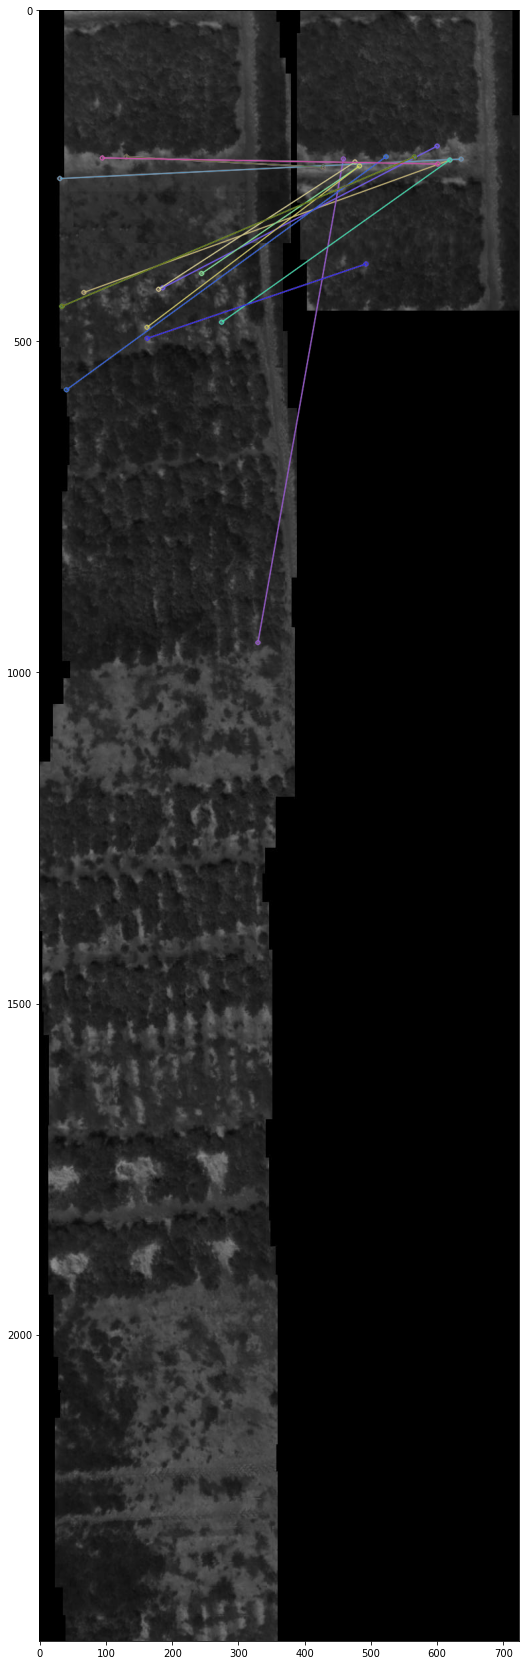

In [56]:
a, b = 1,2
rot = 0
margins = [0,1000,0,1000]#[200,250,0,150]
i, j, k = ks[a], ks[b], 'p'+str(a)+'_'+str(b)
tempfiles = ['strips/'+outName+'_'+str(num)+'.jpg' for num in [i,j]]

feature_extractor, feature_matching = 'orb', 'bf'
arrs = [img_to_arr(tempfiles[0], xq=xq, yq=yq), img_to_arr(tempfiles[1], xq=xq, yq=yq)]
trainImg, queryImg = [imageio.imread(i) for i in tempfiles]
queryImg = np.ma.masked_where(ndimage.rotate(queryImg, rot)<1e-2, ndimage.rotate(queryImg, rot))

trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]
kpsA, featuresA = st.detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = st.detectAndDescribe(queryImg_gray, method=feature_extractor)
matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
fig = plt.figure(figsize=(20,8))
if feature_matching == 'bf':
    matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
elif feature_matching == 'knn':
    matches = st.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
matchesUsed = list(compress(matches,[kpsA[i.queryIdx].pt[0] > margins[0]
                                     and kpsA[i.queryIdx].pt[0] < margins[1]
                                     and kpsA[i.queryIdx].pt[1] > margins[2]
                                     and kpsA[i.queryIdx].pt[1] < margins[3]
                                     for i in matches]))
img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matchesUsed,100),
                       None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(30,30))
plt.imshow(img3)
plt.show()

Raw matches (Brute force): 78


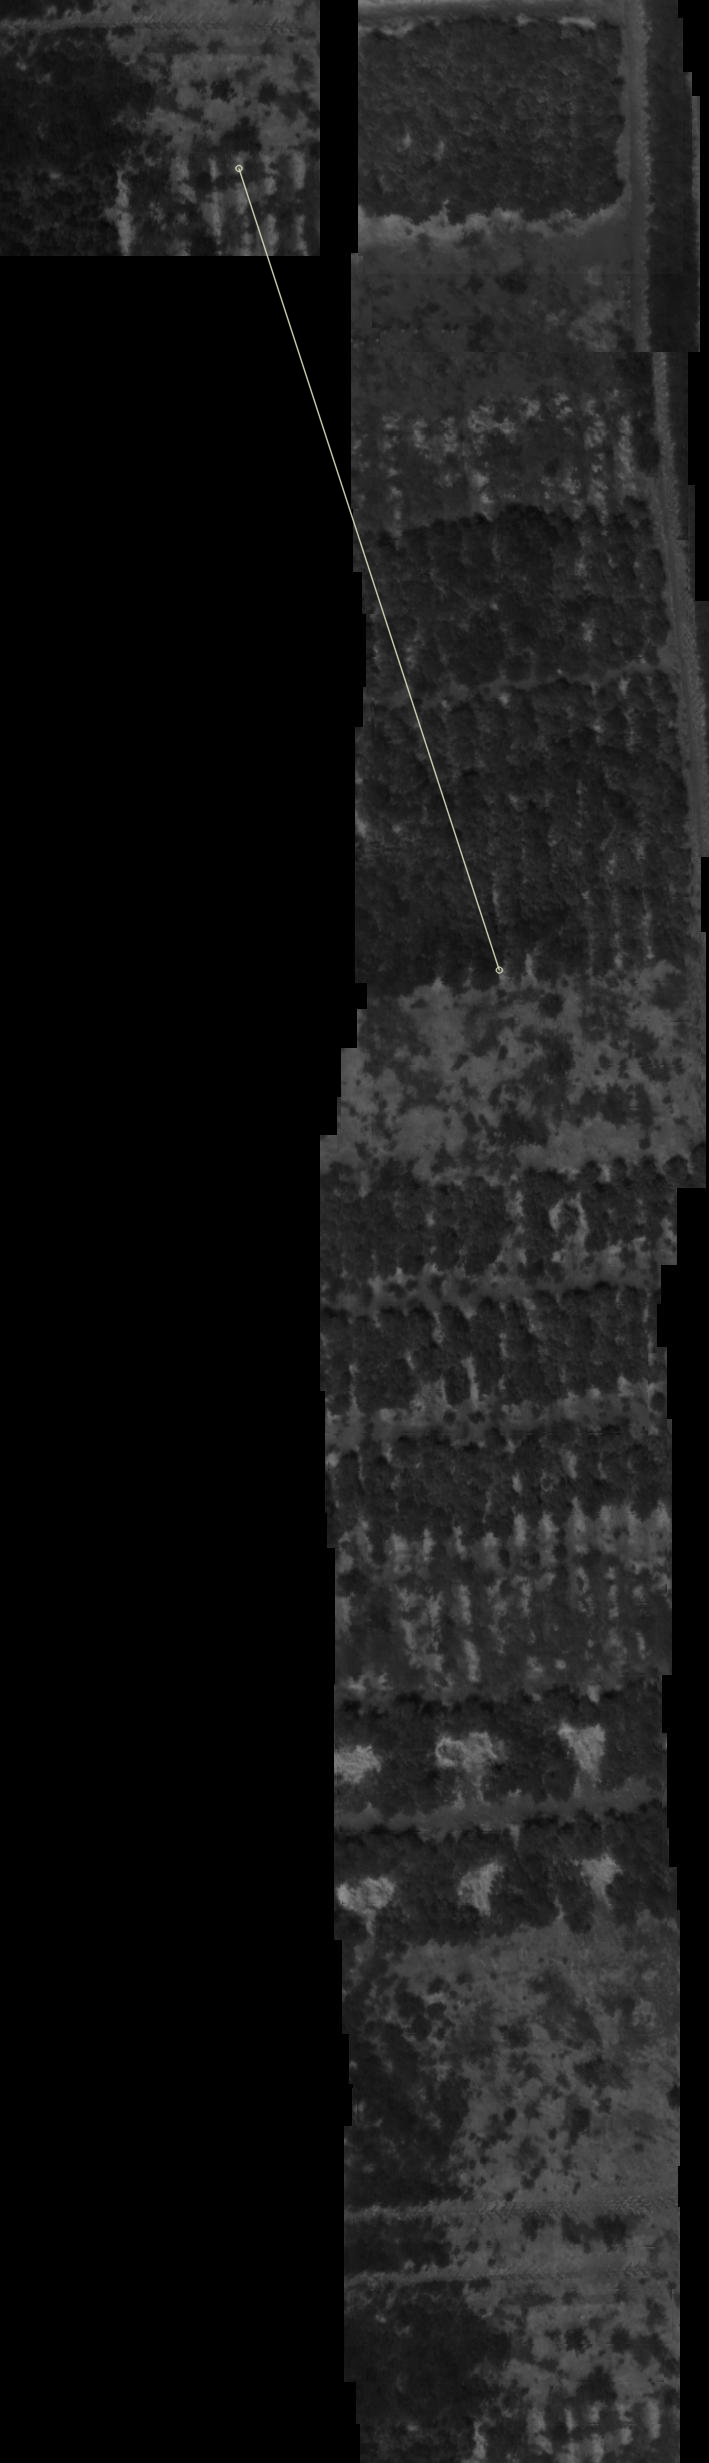

error: ignored

In [64]:
 from google.colab.patches import cv2_imshow
 feature_extractor, feature_matching = 'orb', 'bf'
 i, firstMerge = ks[0], False
for n, val in enumerate(ks[:-1]):
    rot = 0
    #margins = [0,1000,0,1000]#[200,250,0,150]
    j, k = ks[n+1], 'p'+str(n)+'_'+str(n+1)
    tempfiles = ['strips/'+outName+'_'+str(num)+'.jpg' for num in [i,j]]

   
    arrs = [img_to_arr(tempfiles[0], xq=xq, yq=yq), img_to_arr(tempfiles[1], xq=xq, yq=yq)]
    trainImg, queryImg = [imageio.imread(i) for i in tempfiles]
    queryImg = np.ma.masked_where(ndimage.rotate(queryImg, rot)<1e-2, ndimage.rotate(queryImg, rot))

    trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]
    kpsA, featuresA = st.detectAndDescribe(trainImg_gray, method=feature_extractor)
    kpsB, featuresB = st.detectAndDescribe(queryImg_gray, method=feature_extractor)
    matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)

    img = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matchesUsed,1),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    if 'ax' in globals(): del(ax,ay,bx,by)

    cv2_imshow(img)
    #cv2.imshow('merge_'+str(n)+'_'+str(n+1), img)
    cv2.setMouseCallback('merge_'+str(n)+'_'+str(n+1), click_event)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    if 'ax' in globals() and 'bx' in globals():
        diff, ma, mb = [ax-bx+trainImg.shape[1], ay-by], np.array([1]), np.array([1])

        totalBox=[trainImg.shape[0], trainImg.shape[1]]
        prevBox=[0,trainImg.shape[0],0,trainImg.shape[1]]
        prevImg = np.ma.masked_where(trainImg < 1e-1, trainImg)

        totalBox, prevNew, prevImg, prevBox = stitch_img_result_pano(ma, mb, diff, totalBox, prevBox, arrs, prevImg, prevNum=0, imgNum=1,
                            min_matches=0, max_stdev=10000, tmin=-10, tmax=40, verbose=True, rgb_query=queryImg, inv=True)

        single = prevImg.mean(axis=2).astype(np.uint8)
        imageio.imwrite('strips/'+outName+'_'+k+'.jpg',np.dstack((single,single,single)))
        i, firstMerge=k, True
    elif firstMerge is False: i=ks[n+1]


    # #matchesUsed = list(compress(matches,[kpsA[i.queryIdx].pt[0] > margins[0]
    #                                     and kpsA[i.queryIdx].pt[0] < margins[1]
    #                                     and kpsA[i.queryIdx].pt[1] > margins[2]
    #                                     and kpsA[i.queryIdx].pt[1] < margins[3]
    #                                     for i in matches]))
    # img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matchesUsed,100),
    #                     None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # plt.figure(figsize=(30,30))
    # plt.imshow(img3)
    # plt.show()

In [ ]:
from plotly.offline import iplot
import plotly.graph_objs as go

data = [img]
iplot(data)

In [77]:
import plotly.express as px

df = px.data.iris()
fig = px.scatter(df, x="sepal_length", y="sepal_width", facet_col="species")
# sources of images
sources = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Iris_setosa_var._setosa_%282595031014%29.jpg/360px-Iris_setosa_var._setosa_%282595031014%29.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Iris_versicolor_quebec_1.jpg/320px-Iris_versicolor_quebec_1.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Iris_virginica_2.jpg/480px-Iris_virginica_2.jpg",
]
# add images
for col, src in enumerate(sources):
    fig.add_layout_image(
        row=1,
        col=col + 1,
        source=src,
        x=1,
        y=1,
        xanchor="right",
        yanchor="top",
        sizex=1,
        sizey=1)

fig.show()

In [71]:
from plotly.offline import iplot
import plotly.graph_objs as go

data = [
    go.Contour(
        z=[[10, 10.625, 12.5, 15.625, 20],
           [5.625, 6.25, 8.125, 11.25, 15.625],
           [2.5, 3.125, 5., 8.125, 12.5],
           [0.625, 1.25, 3.125, 6.25, 10.625],
           [0, 0.625, 2.5, 5.625, 10]]
    )
]
iplot(data)

In [ ]:
if 'ax' in globals(): del(ax,ay,bx,by)
# reading the image
#img = cv2.imread('strips/NIAB_12m_210804_0.jpg')


# displaying the image
cv2.imshow('image', blank)

# setting mouse hadler for the image
# and calling the click_event() function
cv2.setMouseCallback('image', click_event)

# wait for a key to be pressed to exit
cv2.waitKey(0)

# close the window
cv2.destroyAllWindows()

312   2
700   412


Stitch lines according to matches and an "add" adjustment of pixels.

In [63]:
def click_event(event, x, y, flags, params):

    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:

        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
        global ax,ay,bx,by
        if 'ax' not in globals(): ax, ay = x,y
        else: bx, by = x,y

        # displaying the coordinates
        # on the image window
        # font = cv2.FONT_HERSHEY_SIMPLEX
        # cv2.putText(img, str(x) + ',' +
        #             str(y), (x,y), font,
        #             1, (255, 0, 0), 2)
        # cv2.imshow('image', img)

Filt. matches: 1, stdev: 0.0
Images 0 and 1 merged.


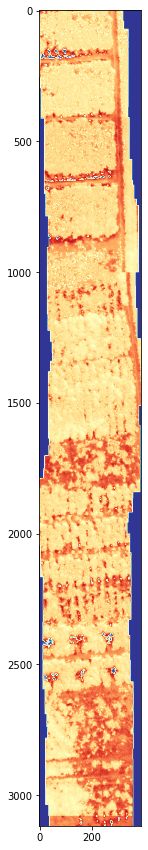

In [ ]:
correct = False
if correct:
    adds = [-38,-510] #[94,-115]
    # Potential to improve by filtering out matches that are not in same direction of travel as drone
    ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matchesUsed]])
    mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matchesUsed]])
    diff = np.median(ma-mb, axis=0).astype(int)+adds
else: diff, ma, mb = [ax-bx+trainImg.shape[1], ay-by], np.array([1]), np.array([1])

totalBox=[trainImg.shape[0], trainImg.shape[1]]
prevBox=[0,trainImg.shape[0],0,trainImg.shape[1]]
prevImg = np.ma.masked_where(trainImg < 1e-1, trainImg)

totalBox, prevNew, prevImg, prevBox = stitch_img_result_pano(ma, mb, diff, totalBox, prevBox, arrs, prevImg, prevNum=0, imgNum=1,
                      min_matches=0, max_stdev=10000, tmin=-10, tmax=40, verbose=True, rgb_query=queryImg, inv=True)

plt.figure(figsize=(15,15))
plt.imshow(prevImg.mean(axis=2),cmap=cmap)
single = prevImg.mean(axis=2).astype(np.uint8)
imageio.imwrite('strips/'+outName+'_'+k+'.jpg',np.dstack((single,single,single)))   

In [ ]:
def stitch_img_result_pano(mam, mbm, diff, totalBox, prevBox, img_arrs, prevImg, prevNum, imgNum,
                           min_matches=4, max_stdev=20, tmin=-10, tmax=40, verbose=True, rgb_query=False,inv=False):
    if verbose: print('Filt. matches: '+str(len(mam))+', stdev: ' + str(round(np.std(mam-mbm, axis=0).mean(),2)))
    # Filter for conditions
    if len(mam) > min_matches and np.std(mam-mbm, axis=0).mean() < max_stdev:
        # New box position before adjustment for expanding total box
        if rgb_query is not False:
            newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[0]+diff[1]))+rgb_query.shape[0], int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[2]+diff[0]))+rgb_query.shape[1]] 
        else: newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[1]+diff[1])), int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[3]+diff[0]))] 
        pos = [0,0] # Position for previously merged images
        modBox = [0,0,0,0] # Position for new image
        # If bounds on axis 0 go beyond total
        if newBox[0]<0 and newBox[1] > totalBox[0]:
            xmin, xmax = imgNum, imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]=newBox[1]-min(newBox[0],0)
        elif newBox[0]<0:
            xmin = imgNum
            modBox[1], modBox[0], pos[0] = newBox[1]-newBox[0], 0, abs(newBox[0])
            totalBox[0]+=abs(newBox[0])
        elif newBox[1] > totalBox[0]:
            xmax = imgNum
            modBox[1], modBox[0] = newBox[1], newBox[0]
            totalBox[0]=newBox[1]
        else: modBox[0], modBox[1] = newBox[0], newBox[1] #newBox[0]>0 and newBox[1] < totalBox[0]:
                 
        # If bounds on axis 1 go beyond total
        if newBox[2]<0 and newBox[3] > totalBox[1]:
            ymin, ymax = imgNum, imgNum
            modBox[3], modBox[2], pos[1] = newBox[3]-newBox[2], 0, abs(newBox[2])
            totalBox[2]=newBox[3]-min(newBox[2],0)
        elif newBox[2]<0:
            ymin = imgNum
            modBox[3], modBox[2], pos[1] = newBox[3]-newBox[2], 0, abs(newBox[2])
            totalBox[1]+=abs(newBox[2])
        elif newBox[3] > totalBox[1]:
            ymax = imgNum
            modBox[3], modBox[2] = newBox[3], newBox[2]
            totalBox[1] = newBox[3] #-min(newBox[2],0)
        else: modBox[2], modBox[3] = newBox[2], newBox[3]
        prevBox = modBox 
        
        if len(img_arrs[1].shape) == 2:
            single = (img_arrs[1]-tmin)*255/tmax
            queryImg = np.dstack((single,single,single)).astype(np.uint8)
        else: queryImg = rgb_query
        result = np.zeros([totalBox[0],totalBox[1],3])
        if inv:
            result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
            prevImg.data[max(0,newBox[0]):min(newBox[1],prevImg.shape[0]), max(0,newBox[2]):min(newBox[3],prevImg.shape[1]),:] += np.array(queryImg[max(0,-newBox[0]):min(queryImg.shape[0],prevImg.shape[0]-max(newBox[0],0)), max(0,-newBox[2]):min(queryImg.shape[1],prevImg.shape[1]+max(-newBox[2],0)),:]*(prevImg.mask[max(0,newBox[0]):min(newBox[1],prevImg.shape[0]), max(0,newBox[2]):min(newBox[3],prevImg.shape[1]),:]))
            result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg   
        else:    
            result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg
            queryImg.data[-min(modBox[0],0):min(modBox[1],prevImg.shape[0])-max(modBox[0],0), -min(modBox[2],0):min(modBox[3],prevImg.shape[1])-max(modBox[2],0)] += np.array(prevImg[modBox[0]:modBox[1], modBox[2]:modBox[3],:]*(queryImg.mask[-min(modBox[0],0):min(modBox[1],prevImg.shape[0])-max(modBox[0],0), -min(modBox[2],0):min(modBox[3],prevImg.shape[1])-max(modBox[2],0)]))
            result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
        print('Images {} and {} merged.'.format(str(prevNum),str(imgNum)))
        prevNum, prevImg = imgNum, result
    else: print('Images {} and {}, poor matching'.format(str(prevNum),str(imgNum)))
    return totalBox, prevNum, prevImg, prevBox

/home/jovyan/s4-thermal/plotting.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


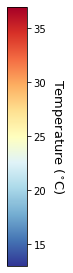

In [ ]:
# Save as .kmz file
tmin,tmax=-10,40
result = np.ma.masked_where(np.dstack((single,single,single))==0, np.dstack((single,single,single)))
extent = [] # Auto get coords from idf
inputCoords = np.array([[0.089216, 0.093611],[52.241702, 52.244020]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is False else inputCoords
cs, first = pl.plot_kml(result.data, conv, outName+'_stitch', 1024*10, rot=90+idf['yaw(deg)'].mean()+19, temp=False, scale=np.array([13,37]), tmin=tmin, tmax=tmax,cmap=cmap, add_temp=17, filt=2)
_, ds = pl.plot_kml(hf.downsample_arr(first,pxSize,resolution), conv, outName+'_ds_stitch', 1024*10, rot=0, scale=first, cmap=cmap)
pl.plot_kml_legend(cs, outName+'_stitchlegend')
pl.plot_kml_path(idf, conv, outName+'_stitchpath', 1024*10)
pl.make_kml(conv, figs=[outName+'_stitch.png', outName+'_ds_stitch.png', outName+'_stitchpath.png'], 
            colorbar=outName+'_stitchlegend.png', kmzfile=outName+'stitch_thermal.kmz',
            description=str(round(pxSize,2))+'m resolution thermal imagery', name='Drone resolution')

In [ ]:
save_to_csv(first, ds, conv, pxSize, resolution, outName+'_stitch', single=True)

In [ ]:
# Save as .csv file
def save_to_csv(arr1, arr2, conv, res1, res2, name, single=False):
    arr_s = arr1.shape
    ptslon = np.linspace(conv[0].min(),conv[0].max(),arr_s[1]+1)[:-1]
    ptslon += (ptslon[1]-ptslon[0])/2
    ptslat = np.linspace(conv[1].min(),conv[1].max(),arr_s[0]+1)[:-1]
    ptslat += (ptslat[1]-ptslat[0])/2
    lonm, latm = np.meshgrid(ptslon,ptslat)
    if single: tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), arr1.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', str(round(res1,2))+'m T(C)'])
    else:
        ds_q = int(np.floor(res1/res2))
        if ds_q>1:
            arr_mod = np.round(arr2[:-(arr2.shape[0] % ds_q),:-(arr2.shape[1] % ds_q)]).astype(int)
            most=np.zeros([len(range(0,arr_mod.shape[0]-ds_q,ds_q))+1, len(range(0,arr_mod.shape[1]-ds_q,ds_q))+1])
            for i in range(0,arr_mod.shape[0],ds_q):
                for j in range(0,arr_mod.shape[1],ds_q):
                    most[int(i/ds_q),int(j/ds_q)] = Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
        else:
            ds_q = int(np.floor(res2/res1))
            arr_mod = np.round(arr1[:-(arr1.shape[0] % ds_q),:-(arr1.shape[1] % ds_q)]).astype(int)
            most=np.zeros([arr1.shape[0], arr1.shape[1]])
            for i in range(0,arr_mod.shape[0],ds_q):
                for j in range(0,arr_mod.shape[1],ds_q):
                    #print(Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0])
                    ct = Counter(arr_mod[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
                    most[int(i/ds_q):int(i/ds_q)+ds_q,int(j/ds_q):int(j/ds_q)+ds_q] = np.array([[ct for y in range(ds_q)] for x in range(ds_q)]) if ct is None else np.array([[ct for y in range(ds_q)] for x in range(ds_q)]).astype(int)

        tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), arr1.reshape(-1,1), most.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', str(round(res1,2))+'m T(C)', str(round(res2, 2))+'m T(C)'])
    filt = tdf[arr1.mask.reshape(-1,1) == False]
    filt.to_csv(name+'.csv', index_label='UID')

In [54]:
def img_to_arr(filepath, xq=False, yq=False):
    if '.npy' in filepath: 
        arr = np.load(filepath)
        if xq and yq: arr = arr[yq:arr.shape[0]-yq,xq:arr.shape[1]-xq]
    else:
        img = imageio.imread(filepath)
        #img = ro.open(filepath)
        read = img[:, yq:img.shape[0]-yq,xq:img.shape[1]-xq] if xq and yq else img
        arr = np.dstack((read[0],read[1],read[2]))/255  
    return arr